In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *

Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 10000
sizeBatch = 32
layerDense = [256, 64, 16, 2]
layerDis = [512, 256]
dimOneHot = 10
dimEncode = layerDense[-1]
factNoise = 0
actDense = 'relu'
nameOptim = 'adam'
# nameOptim = Adam(0.0002, 0.5)

## Load the datasets

In [3]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
# xTrain = (xTrain.astype(np.float32) - 127.5) / 127.5
# xTest = (xTest.astype(np.float32) - 127.5) / 127.5
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


## Construct the encoder and decoder

In [4]:
inputs = Input(shape=(dimInput,))
x = inputs
for numFilt in layerDense[:-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU()(x)
encode = Dense(dimEncode)(x)
encoder = Model(inputs, encode, name='encoder')

inputLatent = Input(shape=(dimEncode,))
x = inputLatent
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU()(x)
x = Dense(dimInput, activation='sigmoid')(x)
decoder = Model(inputLatent, x, name='decoder')

encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
__________

## Construct the autoencoder

In [5]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 218482    
_________________________________________________________________
decoder (Model)              (None, 784)               219264    
Total params: 437,746
Trainable params: 437,746
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
autoencoder.compile(optimizer=nameOptim, 
                    loss='binary_crossentropy')

tic = time()
for epoch in range(numEpochs):
#     for iBatch in range(int(numTrain/sizeBatch)):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, xTrain.shape[0], sizeBatch)
    imgs = xTrain[idx]
    lbl = yTrain[idx]

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = autoencoder.train_on_batch(imgs, imgs)

    # Plot the progress
    print (g_loss)


# history = autoencoder.fit(xTrainNoise, xTrain,
#                 epochs=numEpochs,
#                 sizeBatch=sizeBatch,
#                 shuffle=True,
#                 validation_data=(xTest, xTest))
timeTrain = time() - tic

0.6928239
0.6891141
0.6807208
0.6631086
0.6390134
0.6064321
0.5550728
0.49957216
0.4523497
0.39673424
0.35868675
0.3523388
0.3562523
0.32212707
0.3223782
0.3342904
0.2840228
0.30725405
0.29060543
0.2782683
0.30302173
0.2954714
0.2982975
0.28157735
0.2850316
0.28669667
0.28053164
0.27233428
0.28135198
0.28565142
0.27733845
0.27864608
0.28131786
0.2722277
0.27024546
0.27093184
0.27076995
0.2716235
0.27870193
0.26200014
0.2768039
0.29056954
0.27723423
0.25966826
0.2930923
0.27156347
0.262358
0.29814798
0.2751789
0.27878052
0.27344745
0.2820629
0.26563507
0.2692653
0.26716077
0.27425474
0.27070087
0.2705866
0.27143294
0.27414262
0.28309524
0.25708812
0.26460606
0.26468086
0.2740119
0.27915454
0.26720846
0.22949073
0.27004704
0.25319666
0.24173072
0.26576024
0.26242316
0.26816472
0.26405907
0.2527517
0.26507407
0.25832605
0.272595
0.27167436
0.25560394
0.2600019
0.27307785
0.25297052
0.25507557
0.2673179
0.2591349
0.25862846
0.27969155
0.26648653
0.2718468
0.26367968
0.2607595
0.254835
0.26

0.21926348
0.20998244
0.22459708
0.22229394
0.20138964
0.20247674
0.21584375
0.21710923
0.21574484
0.2104399
0.2132752
0.19711651
0.21622431
0.20501262
0.20693752
0.22152297
0.19626635
0.20194837
0.20268613
0.21885657
0.22669592
0.19754362
0.21780577
0.21829143
0.2129997
0.2247136
0.19901003
0.21645933
0.21324787
0.20535706
0.21822993
0.19960281
0.2057554
0.20229214
0.2063333
0.21839303
0.21369906
0.21576294
0.21570271
0.2000218
0.20411107
0.19162562
0.20877308
0.19799252
0.20778209
0.22415397
0.20347406
0.20432027
0.21247768
0.19407058
0.20658514
0.20848835
0.20918544
0.21009901
0.23064366
0.20209908
0.20634502
0.2102467
0.19897895
0.21023777
0.19455186
0.22591956
0.21894373
0.21152928
0.21786436
0.20499146
0.21464622
0.22804332
0.21947789
0.22741097
0.19394492
0.20410949
0.21332864
0.19723317
0.19926146
0.21378592
0.20644072
0.19100192
0.21246794
0.21214347
0.21148357
0.21173403
0.21068725
0.22502449
0.21057145
0.204476
0.2172445
0.20889583
0.21411256
0.20730665
0.19342864
0.1903536


0.202847
0.21112107
0.2138678
0.20459323
0.18224476
0.20263326
0.19583997
0.18898225
0.21087134
0.19706619
0.21214476
0.2372634
0.19684736
0.21139005
0.22674349
0.19346806
0.18054447
0.20252165
0.19363657
0.2081998
0.20274502
0.21073233
0.19079763
0.19682676
0.20517851
0.19706935
0.19590229
0.19389652
0.1788065
0.20948473
0.18941909
0.19488826
0.21784194
0.19506644
0.20056869
0.18075131
0.21518274
0.20906822
0.19188902
0.2045992
0.19578621
0.21711016
0.20759505
0.21218964
0.18784167
0.20349243
0.19396248
0.23236692
0.22061557
0.16750886
0.19435152
0.20236191
0.19090712
0.2074101
0.19570208
0.22923493
0.20189553
0.1917911
0.18990424
0.19287091
0.20451796
0.19670174
0.18059365
0.19980086
0.19735602
0.18599859
0.18369049
0.18071243
0.19355984
0.21054475
0.19888613
0.19946073
0.20739567
0.18837735
0.2172204
0.19077115
0.2077868
0.21353233
0.18902773
0.19732943
0.20624717
0.21101722
0.19975984
0.21966618
0.20467216
0.17952545
0.21264789
0.19184989
0.20679727
0.18349835
0.20196652
0.18182331

0.18869932
0.19490018
0.20995389
0.18560648
0.21188639
0.20248157
0.201105
0.1829713
0.18692234
0.1860541
0.19731998
0.18901299
0.18136105
0.20340635
0.21067944
0.20110089
0.20254333
0.19053106
0.20310205
0.19267577
0.18915105
0.16606128
0.2113121
0.18370925
0.2036641
0.1806619
0.17291692
0.1891402
0.19049025
0.19348377
0.1915378
0.18631089
0.18494937
0.18417522
0.18131085
0.19976024
0.19470835
0.1979642
0.20169681
0.20110203
0.19185442
0.19552511
0.18599641
0.19146526
0.19780397
0.18068682
0.18524441
0.18902522
0.19106531
0.20625871
0.18021499
0.19348946
0.19488636
0.1929788
0.20256357
0.19149712
0.19607784
0.18182376
0.20001811
0.20459086
0.21084407
0.18090168
0.18771875
0.19069481
0.18554977
0.18608357
0.2027598
0.19535501
0.1848111
0.17902008
0.19762664
0.21595716
0.17753717
0.19446501
0.20851462
0.19979474
0.20398113
0.17128946
0.19671032
0.19272688
0.20673968
0.19235356
0.19025816
0.19149098
0.18487406
0.2011128
0.1841853
0.18894571
0.1786102
0.20717534
0.20819885
0.19439664
0.18

0.2071572
0.18611708
0.20325325
0.19361612
0.17719558
0.19390821
0.17774732
0.19928148
0.18863879
0.19638123
0.21238738
0.20039696
0.20934334
0.20297894
0.19231746
0.18106583
0.19712025
0.18773898
0.1876949
0.18324631
0.19474529
0.17219014
0.19445546
0.19836344
0.20184255
0.18786943
0.17371836
0.19157675
0.18874648
0.22170874
0.19342355
0.20135483
0.19501412
0.2018299
0.18938953
0.20001648
0.18547744
0.19429782
0.19429368
0.21617094
0.19326618
0.19765133
0.18257365
0.20385945
0.2023564
0.19602653
0.18633682
0.20394443
0.18701702
0.17800839
0.17315641
0.17439817
0.19097921
0.20680389
0.19662988
0.19175774
0.19623569
0.17776467
0.16064893
0.2026219
0.19459254
0.18649265
0.18519093
0.19075273
0.17787583
0.177755
0.20793843
0.18801007
0.19283079
0.18938133
0.18789078
0.18301424
0.17549151
0.19713654
0.21963103
0.18629712
0.17753348
0.18488559
0.17701201
0.18311006
0.19768374
0.19193238
0.17141032
0.17209747
0.18725483
0.18965305
0.20103171
0.19817375
0.18317726
0.19208851
0.18224454
0.1853

0.20090778
0.20550367
0.20545495
0.19676271
0.20204104
0.21160367
0.19618255
0.18915571
0.17785114
0.19724834
0.18070728
0.19151796
0.19029048
0.18940738
0.20791894
0.17754012
0.20198607
0.19603749
0.18301967
0.19845362
0.20299709
0.17663728
0.18966922
0.18073359
0.18906574
0.19565302
0.19015269
0.178795
0.17641793
0.22020105
0.19214082
0.18859622
0.1873066
0.19190341
0.19437043
0.18750715
0.18783909
0.21126989
0.18978234
0.20455588
0.18298575
0.17806327
0.1938439
0.20749377
0.16758126
0.2019721
0.19922091
0.17676076
0.1878478
0.18763947
0.19855776
0.1857234
0.20162213
0.19116524
0.19641143
0.19490515
0.19110787
0.1727683
0.1852659
0.17854801
0.17460169
0.17710988
0.18789932
0.19422665
0.1729901
0.19854379
0.1977606
0.19929396
0.1849792
0.20737082
0.19157144
0.19765234
0.19230999
0.19270498
0.18918587
0.18229952
0.18811785
0.19613196
0.17880648
0.18410741
0.19423501
0.16741705
0.18362017
0.16884941
0.17470178
0.20097136
0.19135395
0.18816692
0.19457474
0.20501813
0.18787198
0.17426246


0.18349722
0.19150823
0.17245236
0.17973337
0.19641921
0.19537926
0.1760351
0.19266887
0.19417018
0.19066864
0.20623207
0.20062217
0.18807322
0.17857672
0.20019683
0.16014008
0.19846539
0.19054917
0.19595885
0.18499045
0.19453853
0.19340473
0.19215786
0.17824794
0.18857408
0.20440271
0.20511281
0.17919621
0.19897862
0.17829183
0.17048028
0.1913681
0.19658442
0.1967332
0.18102297
0.19102168
0.1799029
0.16330433
0.19750157
0.17983614
0.18402708
0.20295236
0.19653755
0.1860499
0.1638948
0.18551268
0.1927304
0.1927675
0.1792139
0.20142245
0.18006724
0.1957811
0.18723935
0.20715508
0.18288325
0.18531775
0.18708831
0.18205795
0.18760352
0.20365149
0.17212254
0.20204315
0.19867061
0.1927143
0.18465546
0.19090922
0.1821222
0.18120861
0.1821734
0.19897178
0.17929879
0.18286479
0.16615695
0.19333974
0.17960772
0.20755933
0.17739058
0.17700936
0.19186436
0.18352553
0.17777063
0.19071391
0.17906798
0.19047727
0.19622412
0.19994706
0.19020501
0.18276651
0.1898188
0.16863927
0.18550885
0.18850991
0.

0.19356048
0.19039425
0.20218435
0.18749318
0.19993645
0.19486946
0.1749382
0.18041687
0.18572867
0.19053234
0.17851876
0.18406892
0.1824799
0.18931615
0.18602452
0.19571233
0.17506802
0.21304259
0.18890098
0.18345103
0.18803677
0.18456785
0.18772401
0.18411778
0.21053421
0.17640829
0.1848889
0.20102388
0.18123636
0.19251269
0.18863754
0.1734617
0.17204317
0.19764704
0.18653917
0.20534343
0.18312202
0.18498619
0.1954616
0.18208124
0.17164388
0.19028395
0.19527215
0.17339689
0.19436218
0.18220308
0.18806535
0.1704078
0.18281525
0.17077696
0.16739851
0.1956487
0.19974715
0.19544531
0.19536157
0.18720481
0.18924643
0.20002662
0.20611879
0.19039488
0.1863654
0.17104384
0.18135804
0.18242747
0.19525823
0.19240661
0.1878725
0.19511406
0.17069122
0.18582289
0.19974321
0.17195264
0.19593176
0.1906023
0.1872465
0.178745
0.17315015
0.19885941
0.20724438
0.20247045
0.17964518
0.19110343
0.17237166
0.18949625
0.1899744
0.18532723
0.18148318
0.19040224
0.19482028
0.17834333
0.18933158
0.19587563
0.

0.19792375
0.17119697
0.17199525
0.18917853
0.17087662
0.17903605
0.1747736
0.16658975
0.17208043
0.19329426
0.19425988
0.18951523
0.18035367
0.20563951
0.18039063
0.18986335
0.19654469
0.19319908
0.1892331
0.19110179
0.18139565
0.17224044
0.18522906
0.18482952
0.18867832
0.1749761
0.17907374
0.18733191
0.17963167
0.16165645
0.18812427
0.18628238
0.17121908
0.19700517
0.19184679
0.18705681
0.17760286
0.18511993
0.19324063
0.19395015
0.18954685
0.1870153
0.18785426
0.18036228
0.18462284
0.17625855
0.19200443
0.18346027
0.18087342
0.17249098
0.18527313
0.19045147
0.17860098
0.19487
0.1784688
0.188332
0.19420308
0.17654595
0.17826086
0.18973717
0.1701466
0.17979354
0.19082037
0.1744546
0.18478698
0.18462577
0.18694787
0.164803
0.2106916
0.18703127
0.1886127
0.17742278
0.17296891
0.16999607
0.17990041
0.1883972
0.19197024
0.17635687
0.20830306
0.18301979
0.17810911
0.19810483
0.18661578
0.19550362
0.18318886
0.17913145
0.18349189
0.1899141
0.20130365
0.18415642
0.182027
0.17474806
0.175949

0.16040894
0.19325325
0.17745332
0.19023025
0.19064927
0.19090708
0.18232688
0.177158
0.22706108
0.18384409
0.17386064
0.18365443
0.1843602
0.18245825
0.16928582
0.1785785
0.17945516
0.18591297
0.22078562
0.18440576
0.16037787
0.1720364
0.16775267
0.18891762
0.17364663
0.20027459
0.15662381
0.1908055
0.18542036
0.17440814
0.179303
0.18427606
0.1792643
0.18537179
0.18397598
0.1702916
0.17176205
0.17090881
0.185081
0.18580648
0.19611415
0.19620645
0.18614471
0.1893675
0.18304034
0.1868354
0.18722066
0.17267507
0.1820316
0.17579383
0.17455369
0.18618488
0.18857609
0.20778272
0.18530717
0.18119253
0.18299127
0.18578015
0.16833314
0.18920329
0.17604429
0.17491984
0.1940971
0.18107095
0.18109453
0.19345114
0.18000187
0.17042163
0.18541689
0.20092402
0.1738218
0.19991714
0.1743631
0.22049232
0.18501326
0.18068878
0.1931878
0.18921766
0.17868307
0.19194034
0.18238255
0.16635649
0.18953605
0.17189279
0.2024279
0.19027112
0.19466433
0.17455453
0.17219979
0.18493909
0.18208602
0.19498807
0.190656

0.17441046
0.1898309
0.16857424
0.17352915
0.17825568
0.19446675
0.18483013
0.19680235
0.17606421
0.17227815
0.18604901
0.18233842
0.17804514
0.16416338
0.19227947
0.1926204
0.18920228
0.17060766
0.18207797
0.1739828
0.16843124
0.18441051
0.18005322
0.18516529
0.17723095
0.1801656
0.18954834
0.18205306
0.20344293
0.19051772
0.17187051
0.19158106
0.17414674
0.1765753
0.18495049
0.17879279
0.1850113
0.18684208
0.18432604
0.1812731
0.17756394
0.20522685
0.17260686
0.19455692
0.18490867
0.19020075
0.1959725
0.19299075
0.16717932
0.18081234
0.17893061
0.1715315
0.19183415
0.1981733
0.17013593
0.1903648
0.18856952
0.18777622
0.18732291
0.176433
0.18425754
0.18779123
0.18449956
0.18855904
0.1875101
0.19717121
0.19094992
0.17590238
0.17584044
0.16927712
0.17117062
0.1818895
0.19935913
0.17208403
0.18476565
0.18792643
0.1970945
0.16783348
0.19201547
0.17163959
0.17080554
0.19101468
0.1840997
0.18258676
0.16003601
0.1923641
0.18123573
0.17886044
0.19015348
0.18244584
0.19020736
0.18149571
0.1892

0.1726654
0.18299942
0.2018716
0.1845487
0.17782341
0.18512155
0.19325826
0.18432026
0.18323405
0.18602756
0.16773532
0.18025868
0.18909845
0.16954815
0.19993281
0.17582811
0.18249059
0.17314811
0.17658278
0.1876618
0.18296593
0.17142068
0.18657696
0.16853996
0.17315416
0.17101532
0.18645842
0.1780544
0.17977244
0.17579238
0.19885156
0.18182659
0.19364664
0.19644552
0.18895349
0.16977656
0.20119545
0.20048928
0.1974491
0.19684756
0.18139921
0.18370813
0.18211557
0.1775505
0.16989808
0.17789134
0.1708854
0.1664618
0.17508408
0.18993752
0.16704834
0.18000755
0.17042536
0.2031456
0.17335698
0.18621403
0.20174336
0.17468539
0.18525618
0.20392123
0.19534908
0.1804204
0.16045788
0.16289288
0.17606261
0.1780847
0.19075987
0.17194964
0.1888934
0.18571244
0.18700218
0.19716325
0.20761591
0.17709021
0.19831587
0.19291681
0.17874202
0.16817631
0.17563447
0.1874273
0.17840362
0.1805036
0.20393726
0.1695207
0.19301604
0.17087564
0.19520307
0.19385158
0.19849443
0.18664443
0.1808213
0.19383007
0.188

0.19187379
0.19554892
0.19139138
0.17114402
0.16374917
0.1645852
0.19294986
0.20638114
0.19828692
0.18048526
0.19626705
0.20306203
0.18099731
0.1910953
0.17503935
0.17371112
0.18862551
0.18130945
0.19452569
0.19714326
0.1948104
0.17554097
0.18091731
0.19257414
0.17534083
0.17637831
0.16634864
0.18144046
0.19349386
0.17351462
0.1850752
0.19372514
0.1730653
0.19512363
0.18452385
0.17414534
0.18696496
0.17248124
0.19412735
0.1778695
0.19770677
0.15980434
0.18760428
0.18323389
0.16762367
0.171559
0.1979385
0.18425828
0.18321267
0.16861752
0.17691162
0.18037954
0.17611203
0.16605926
0.18240586
0.15551889
0.17171925
0.15893057
0.18850397
0.17236426
0.18051448
0.17015776
0.19539192
0.1810115
0.19661847
0.17635395
0.16445231
0.17020601
0.16808456
0.17353249
0.19123513
0.16908479
0.17684849
0.16939712
0.1926281
0.18346824
0.19756761
0.1923136
0.18612136
0.16639969
0.2028701
0.17693384
0.1764507
0.17702821
0.18712683
0.17584106
0.19293214
0.19392724
0.17516768
0.17557748
0.17955059
0.18196824
0.

## Show the historical training progress 

In [7]:
print("traing consumed: " + str(timeTrain) + " seconds")
# plotProgress(history)

traing consumed: 47.843185901641846 seconds


## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

In [92]:
oh_loss_real

[0.81814206, 0.21875]

[[0.99999976]]


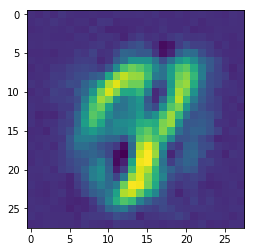

In [39]:
indx = 8
gener = np.zeros([1,10])
gener[:,indx] = 1
print(disOneHot.predict(gener))
decodeTest2 = decoder.predict([[[0, 0.]], gener])
plt.imshow(decodeTest2.reshape(28,28))

## Compare original digitals with the decoding results

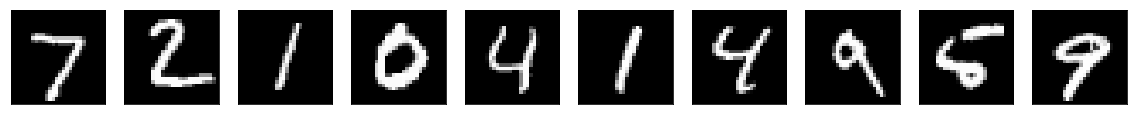

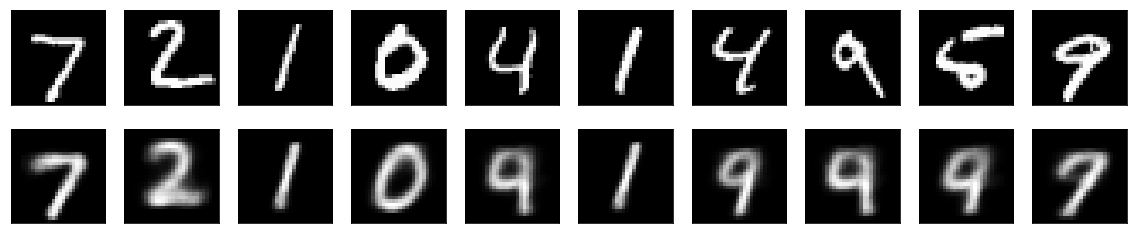

In [9]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

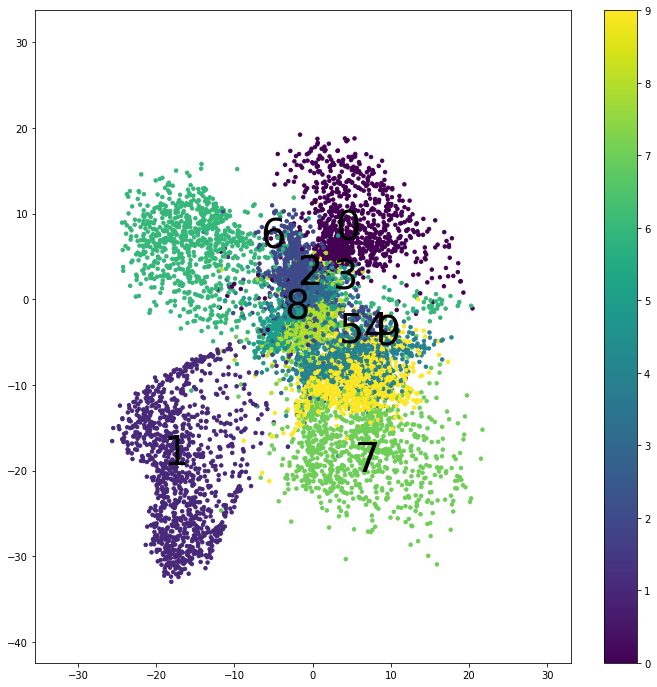

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

In [15]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[-4.33721217, -4.06841657]])]...

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [ ]:
plt.imshow(decoder.predict([[0, 0], [1,0,0,0,0,0,0,0,0,0]]).reshape(28,28))

In [ ]:
plt.imshow(decoder.predict([encodeTest[0,:], encodeOneHotTest[0,:]]).reshape(28,28))